In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE= 256
BATCH_SIZE=32

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/PlantDisease/PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 20641 files belonging to 15 classes.


In [4]:
class_names=dataset.class_names

In [5]:
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[ 3 10  8  9 10 12  6 12 12  9 11  2  3 10 11  3  6  5  2  7  5  5  6  7
  1  9  2  5  0 10 12 12]


In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0])

tf.Tensor(
[[[150. 150. 150.]
  [149. 149. 149.]
  [149. 149. 149.]
  ...
  [165. 169. 168.]
  [165. 169. 168.]
  [166. 170. 169.]]

 [[147. 147. 147.]
  [146. 146. 146.]
  [146. 146. 146.]
  ...
  [165. 169. 168.]
  [165. 169. 168.]
  [165. 169. 168.]]

 [[146. 146. 146.]
  [145. 145. 145.]
  [145. 145. 145.]
  ...
  [164. 168. 167.]
  [165. 169. 168.]
  [165. 169. 168.]]

 ...

 [[ 75.  76.  71.]
  [ 77.  78.  73.]
  [ 78.  79.  74.]
  ...
  [124. 129. 123.]
  [123. 128. 122.]
  [123. 128. 122.]]

 [[ 76.  77.  72.]
  [ 75.  76.  71.]
  [ 75.  76.  71.]
  ...
  [126. 131. 125.]
  [127. 132. 126.]
  [127. 132. 126.]]

 [[ 79.  80.  75.]
  [ 76.  77.  72.]
  [ 74.  75.  70.]
  ...
  [129. 134. 128.]
  [130. 135. 129.]
  [130. 135. 129.]]], shape=(256, 256, 3), dtype=float32)


In [8]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy)

<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[186., 183., 192.],
        [194., 191., 200.],
        [199., 196., 205.],
        ...,
        [162., 160., 174.],
        [170., 168., 182.],
        [179., 177., 191.]],

       [[197., 194., 203.],
        [207., 204., 213.],
        [211., 208., 217.],
        ...,
        [167., 165., 179.],
        [170., 168., 182.],
        [173., 171., 185.]],

       [[204., 201., 210.],
        [214., 211., 220.],
        [220., 217., 226.],
        ...,
        [171., 169., 183.],
        [171., 169., 183.],
        [169., 167., 181.]],

       ...,

       [[157., 147., 156.],
        [168., 158., 167.],
        [166., 156., 165.],
        ...,
        [154., 148., 160.],
        [173., 167., 179.],
        [150., 144., 156.]],

       [[168., 158., 167.],
        [170., 160., 169.],
        [152., 142., 151.],
        ...,
        [157., 151., 163.],
        [146., 140., 152.],
       

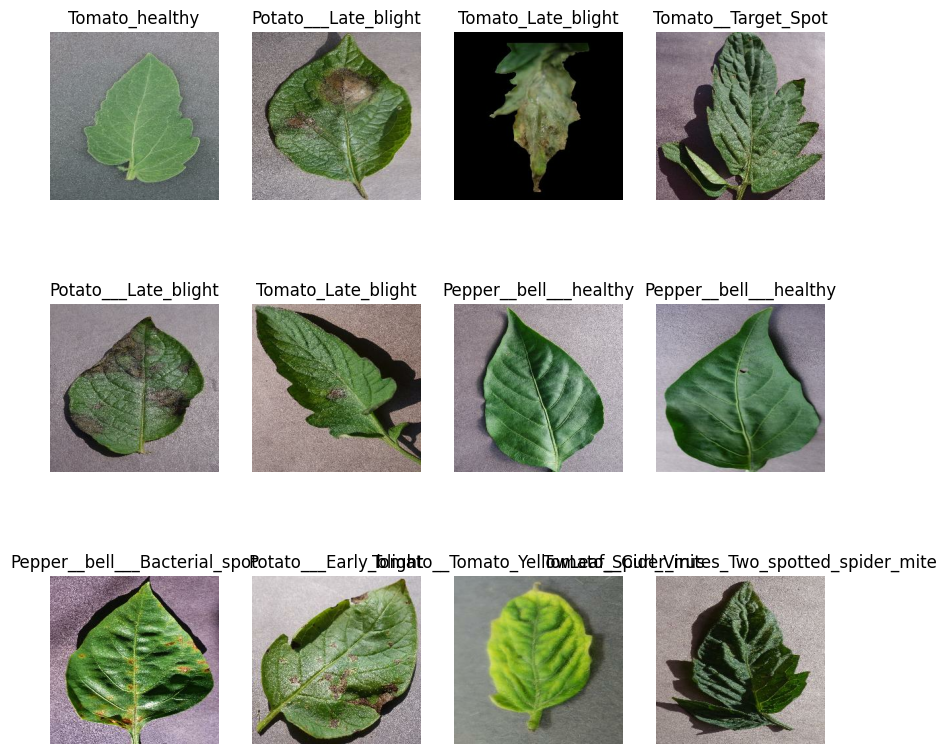

In [12]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(2):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8")) #convert into the integers as it is the float
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [13]:
def dataset_partitioning_tf(dataset,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True, shuffle_size=1000):
    ds_size=len(dataset)
    
    if shuffle:
        dataset=dataset.shuffle(shuffle_size,seed=12)#seed is for just predictability same seed every time it will give you same result
    
    train_size=int(ds_size*train_split)
    val_size=int(ds_size*val_split)
    test_size=int(ds_size*test_split)
    
    train_ds=dataset.take(train_size)
    rem_ds=dataset.skip(train_size)
    val_ds=rem_ds.take(val_size)
    test_ds=rem_ds.skip(val_size)
    
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds=dataset_partitioning_tf(dataset)

In [15]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

516
64
66


In [16]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
#this improve the preformance of pipeline as it stores the images in cache
#if we are using GPU or CPU if GPU is busy taining prefetch will load the next set of batch from your disk that will improve the performance

In [17]:
#scaling the numpy array between 0-1 by dviding it by 255 (rgb)
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [19]:
# data augmentaion
data_augmentaion=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])


In [21]:
CHANNELS = 3
input_shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=15
# base_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
# base_model.summary()
inputs = tf.keras.Input(shape=input_shape)
x = resize_and_rescale(inputs)
x = data_augmentaion(x)
base_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)

# Add additional layers on top of the base model
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(n_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328 

In [22]:
# model=models.Sequential([
#     base_model,
#     layers.Flatten(),
#     layers.Dense(64,activation='relu'),
#     layers.Dense(64,activation='relu'),
#     layers.Dense(n_classes,activation='softmax')
# ])
# model.summary()

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
EPOCHS=50

In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
    
)

In [27]:
model_vesion=4
model.save(f"/content/drive/MyDrive/PlantDisease/models/{model_vesion}")

In [28]:
import numpy as np

In [29]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [30]:
import matplotlib.pyplot as plt

In [31]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

Output hidden; open in https://colab.research.google.com to view.

In [32]:
history.history['accuracy']

[0.17017926275730133,
 0.3010537922382355,
 0.46166422963142395,
 0.5588662624359131,
 0.6106467843055725,
 0.654009222984314,
 0.674358069896698,
 0.6990067958831787,
 0.7228076457977295,
 0.7566618323326111,
 0.7661094665527344,
 0.7866400480270386,
 0.8104408979415894,
 0.8252785801887512,
 0.8345445990562439,
 0.8463541865348816,
 0.8608284592628479,
 0.8661579489707947,
 0.8650072813034058,
 0.8760901093482971,
 0.8828125,
 0.8829941749572754,
 0.8841448426246643,
 0.8918967843055725,
 0.8946826457977295,
 0.9041303396224976,
 0.8915334343910217,
 0.9150920510292053,
 0.9141836166381836,
 0.916000485420227,
 0.9103682041168213,
 0.9153342843055725,
 0.9235101938247681,
 0.9112160801887512,
 0.9151526093482971,
 0.9255087375640869,
 0.929384708404541,
 0.9266594052314758,
 0.9245397448539734,
 0.9230256676673889,
 0.911821722984314,
 0.9322311282157898,
 0.9131540656089783,
 0.9356831312179565,
 0.9348958134651184,
 0.931928277015686,
 0.9379844665527344,
 0.9318677186965942,
 0.93

In [33]:
scores = model.evaluate(test_ds)

66/66 [==============================] - 2s 29ms/step - loss: 0.2601 - accuracy: 0.9134


In [34]:
scores

[0.2601318657398224, 0.9133522510528564]

In [35]:
history

In [36]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 516}

In [37]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [38]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation loss')

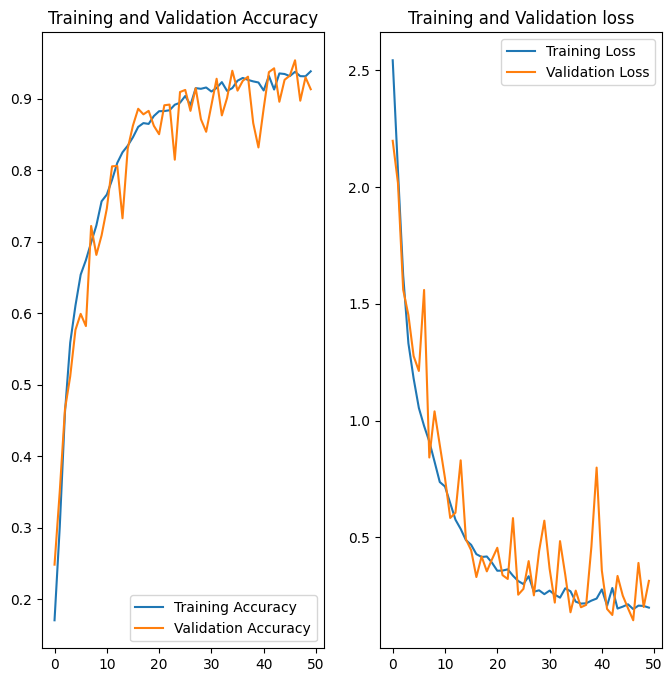

In [39]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc, label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc, label='Validation Accuracy')
plt.legend()
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss, label='Training Loss')
plt.plot(range(EPOCHS),val_loss, label='Validation Loss')
plt.legend()
plt.title("Training and Validation loss")

first image to predict
actual label: Pepper__bell___Bacterial_spot
1/1 [==============================] - 0s 33ms/step
predicted label: Pepper__bell___Bacterial_spot


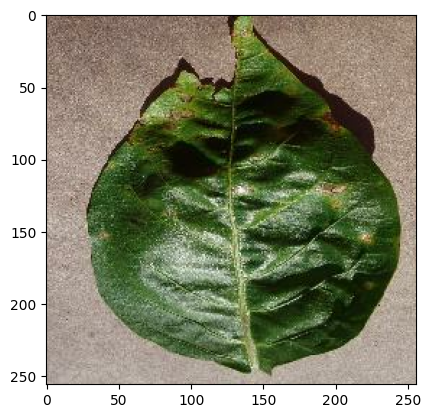

In [40]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [41]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [42]:
import matplotlib.pyplot as plt

In [43]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
##GOOGLE NET (InceptionV1)

In [44]:
CHANNELS = 3
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 15

In [49]:
# Add the preprocessing layers to the input
inputs = tf.keras.Input(shape=input_shape)
x = resize_and_rescale(inputs)
x = data_augmentaion(x)

# Use GoogleNet/InceptionV1 as the base model
base_model =tf.keras.applications.inception_v3.InceptionV3(weights="imagenet", include_top=False, input_shape=input_shape)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)

# Add additional layers on top of the base model
x = layers.Dense(1024, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(n_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 1024)              20981

In [50]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [51]:
EPOCHS=50
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
    
)

Epoch 1/50
516/516 [==============================] - 77s 72ms/step - loss: 0.6749 - accuracy: 0.8026 - val_loss: 0.6630 - val_accuracy: 0.8062
Epoch 2/50
516/516 [==============================] - 35s 68ms/step - loss: 0.3273 - accuracy: 0.9006 - val_loss: 0.4193 - val_accuracy: 0.8779
Epoch 3/50
516/516 [==============================] - 35s 68ms/step - loss: 0.2289 - accuracy: 0.9297 - val_loss: 0.2800 - val_accuracy: 0.9116
Epoch 4/50
516/516 [==============================] - 35s 68ms/step - loss: 0.2574 - accuracy: 0.9248 - val_loss: 1.7121 - val_accuracy: 0.6577
Epoch 5/50
516/516 [==============================] - 35s 68ms/step - loss: 0.1711 - accuracy: 0.9461 - val_loss: 0.4553 - val_accuracy: 0.8687
Epoch 6/50
516/516 [==============================] - 35s 68ms/step - loss: 0.1416 - accuracy: 0.9558 - val_loss: 0.0764 - val_accuracy: 0.9766
Epoch 7/50
516/516 [==============================] - 35s 68ms/step - loss: 0.1680 - accuracy: 0.9486 - val_loss: 0.3725 - val_accuracy:

In [52]:
model_vesion=5
model.save(f"/content/drive/MyDrive/PlantDisease/models/{model_vesion}")

In [53]:
scores = model.evaluate(test_ds)

66/66 [==============================] - 1s 19ms/step - loss: 0.2657 - accuracy: 0.9432


Text(0.5, 1.0, 'Training and Validation loss')

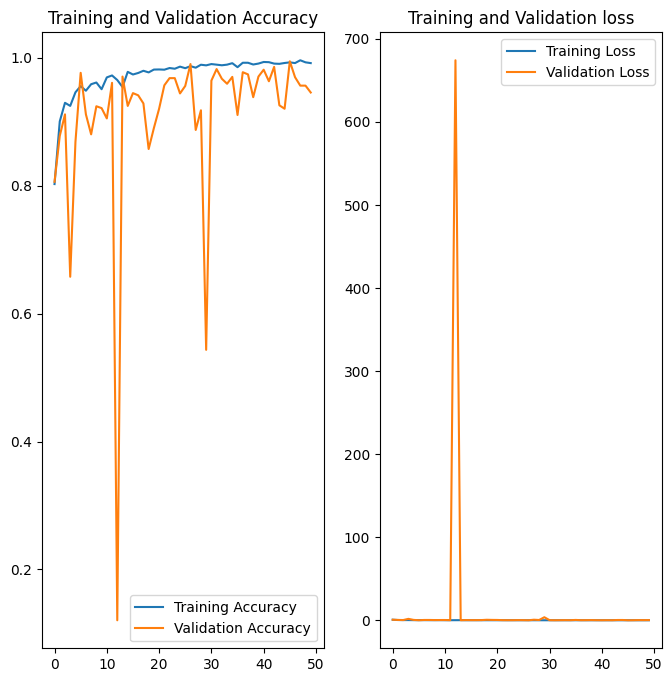

In [54]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc, label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc, label='Validation Accuracy')
plt.legend()
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss, label='Training Loss')
plt.plot(range(EPOCHS),val_loss, label='Validation Loss')
plt.legend()
plt.title("Training and Validation loss")


In [55]:
# Add the preprocessing layers to the input
inputs = tf.keras.Input(shape=input_shape)
x = resize_and_rescale(inputs)
x = data_augmentaion(x)

# Use VGG19 as the base model
base_model = tf.keras.applications.VGG19(weights="imagenet", include_top=False, input_shape=input_shape)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)

# Add additional layers on top of the base model
x = layers.Dense(1024, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(n_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

80134624/80134624 [==============================] - 1s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 1024)              52531

In [56]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [57]:
EPOCHS=50
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
    
)

Epoch 1/50
516/516 [==============================] - 52s 87ms/step - loss: 2.3784 - accuracy: 0.2194 - val_loss: 17.8533 - val_accuracy: 0.1392
Epoch 2/50
516/516 [==============================] - 45s 86ms/step - loss: 2.1392 - accuracy: 0.2703 - val_loss: 21.4465 - val_accuracy: 0.0771
Epoch 3/50
516/516 [==============================] - 45s 86ms/step - loss: 2.0592 - accuracy: 0.2919 - val_loss: 2.5253 - val_accuracy: 0.2236
Epoch 4/50
516/516 [==============================] - 44s 86ms/step - loss: 2.0096 - accuracy: 0.3073 - val_loss: 19.3541 - val_accuracy: 0.1392
Epoch 5/50
516/516 [==============================] - 44s 86ms/step - loss: 1.9964 - accuracy: 0.3146 - val_loss: 6.1856 - val_accuracy: 0.0801
Epoch 6/50
516/516 [==============================] - 44s 86ms/step - loss: 1.9443 - accuracy: 0.3327 - val_loss: 4.1263 - val_accuracy: 0.1943
Epoch 7/50
516/516 [==============================] - 44s 86ms/step - loss: 1.9259 - accuracy: 0.3367 - val_loss: 3.1045 - val_accura

In [58]:
model_vesion=6
model.save(f"/content/drive/MyDrive/PlantDisease/models/{model_vesion}")

In [60]:
scores = model.evaluate(test_ds)

66/66 [==============================] - 2s 33ms/step - loss: 0.3649 - accuracy: 0.8991


Text(0.5, 1.0, 'Training and Validation loss')

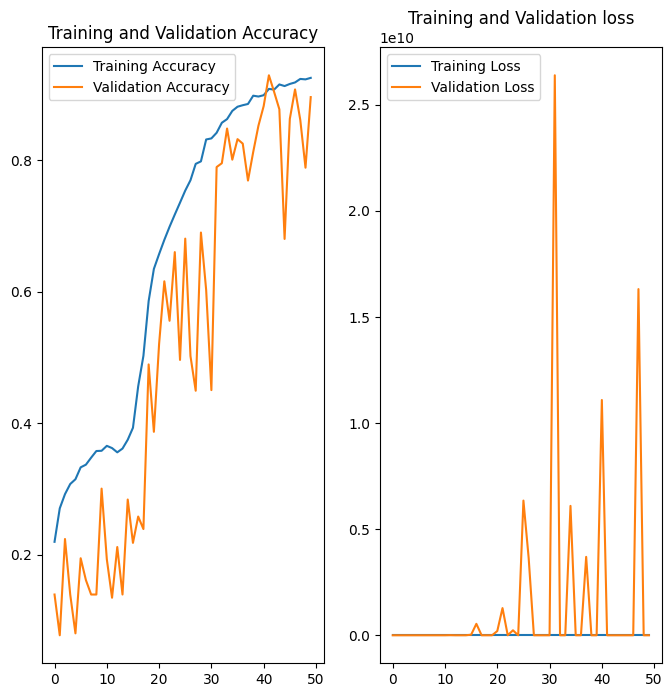

In [61]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc, label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc, label='Validation Accuracy')
plt.legend()
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss, label='Training Loss')
plt.plot(range(EPOCHS),val_loss, label='Validation Loss')
plt.legend()
plt.title("Training and Validation loss")

In [62]:
CHANNELS = 3
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 15


# Add the preprocessing layers to the input
inputs = tf.keras.Input(shape=input_shape)
x = resize_and_rescale(inputs)
x =data_augmentaion(x)

# Use DenseNet201 as the base model
base_model = tf.keras.applications.DenseNet201(weights="imagenet", include_top=False, input_shape=input_shape)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)

# Add additional layers on top of the base model
x = layers.Dense(1024, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(n_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()


74836368/74836368 [==============================] - 1s 0us/step
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 densenet201 (Functional)    (None, 8, 8, 1920)        18321984  
                                                                 
 global_average_pooling2d_3   (None, 1920)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 1024)              19671

In [63]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [64]:
EPOCHS=50
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
    
)

Epoch 1/50
516/516 [==============================] - 209s 174ms/step - loss: 0.5146 - accuracy: 0.8461 - val_loss: 0.6789 - val_accuracy: 0.8110
Epoch 2/50
516/516 [==============================] - 87s 168ms/step - loss: 0.2165 - accuracy: 0.9316 - val_loss: 0.4958 - val_accuracy: 0.8599
Epoch 3/50
516/516 [==============================] - 86s 167ms/step - loss: 0.1645 - accuracy: 0.9453 - val_loss: 1.8173 - val_accuracy: 0.6655
Epoch 4/50
516/516 [==============================] - 86s 167ms/step - loss: 0.1274 - accuracy: 0.9576 - val_loss: 0.7293 - val_accuracy: 0.7847
Epoch 5/50
516/516 [==============================] - 86s 168ms/step - loss: 0.1195 - accuracy: 0.9620 - val_loss: 0.2141 - val_accuracy: 0.9395
Epoch 6/50
516/516 [==============================] - 86s 167ms/step - loss: 0.1019 - accuracy: 0.9675 - val_loss: 0.5653 - val_accuracy: 0.8779
Epoch 7/50
516/516 [==============================] - 86s 167ms/step - loss: 0.0973 - accuracy: 0.9679 - val_loss: 1.7009 - val_a

In [65]:
model_vesion=7
model.save(f"/content/drive/MyDrive/PlantDisease/models/{model_vesion}")

In [66]:
scores = model.evaluate(test_ds)

66/66 [==============================] - 3s 40ms/step - loss: 0.0693 - accuracy: 0.9882


Text(0.5, 1.0, 'Training and Validation loss')

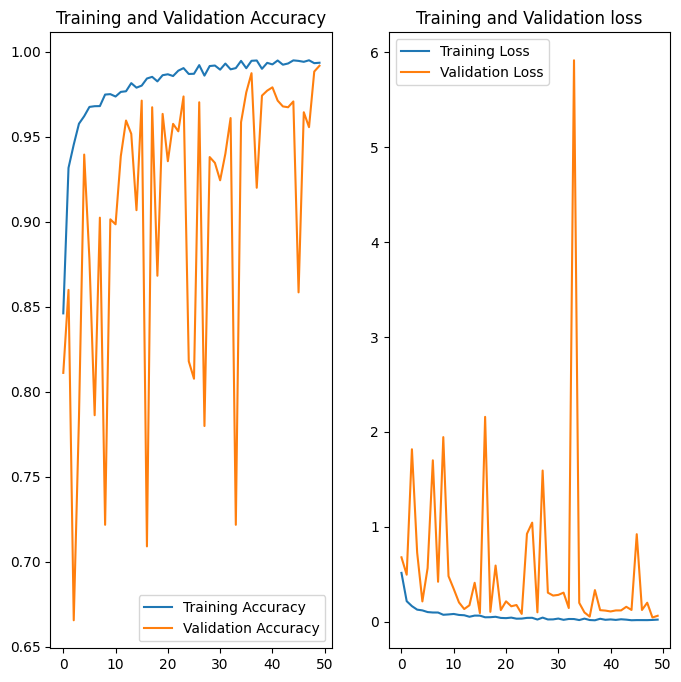

In [67]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc, label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc, label='Validation Accuracy')
plt.legend()
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss, label='Training Loss')
plt.plot(range(EPOCHS),val_loss, label='Validation Loss')
plt.legend()
plt.title("Training and Validation loss")

In [ ]:
CHANNELS = 3
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 15


# Add the preprocessing layers to the input
inputs = tf.keras.Input(shape=input_shape)
x = resize_and_rescale(inputs)
x = data_augmentaion(x)

# Use AlexNet as the base model
base_model = tf.keras.applications.AlexNet(weights="imagenet", include_top=False, input_shape=input_shape)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)

# Add additional layers on top of the base model
x = layers.Dense(1024, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(n_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()
